In [9]:
import networkx as nx
import time
import json
import matplotlib.pyplot as plt

# 1 Echauffement

Afin de convertir le format de données json au graphe, la conversion fut en 3 étapes : json -> dict() -> Graph(). Nous pourrions directement convertir du json à un graphe networkX, mais la conversion en dictionnaire permet de traiter les données hors cast et le temps d'execution étant faible (3s en moyenne pour la conversion en dico avec le set de donnée entier), on peut se le permettre.

Le format adopté :
{Nom_du_Film : {cast : [liste_des_acteurs]}, {director : [liste_des_directeurs]}, {producers : [liste_des_producteurs]}, {companies: [liste_des_companies]}, {year: [Date_de_sorti]}}

## json -> dict()

In [26]:

def convert_txt_to_dict(nom_fichier):
    """charge un fichier de lignes json en dictionnaire 

    Args:
        nom_fichier (str): nom du fichier txt contenant les lignes json

    Returns:
        dict: le dictionnaire avec le contenus du fichier
    """
    with open(nom_fichier, encoding='utf-8') as fichier_open:
        lignes = fichier_open.readlines()
        dico = {}
        for json_data in lignes:
            # gestion des symboles [[]] |
            Data = json.loads(json_data)
            titre = Data["title"].replace("[[", "").replace("]]", "")
            cast = [personne.split("|")[0].split("(")[0].replace("[[", "").replace("]]", "") if "|" in personne else personne.replace("[[", "").replace("]]", "") for personne in Data.get("cast", [])]
            directeur = [director.replace("[[", "").replace("]]", "") for director in Data.get("directors", [])]
            producteur = [prod.replace("[[", "").replace("]]", "") for prod in Data.get("producers", [])]
            companies = [comp.replace("[[", "").replace("]]", "") for comp in Data.get("companies", [])]
            annee_sorti = Data.get("year", [])
            
            dico[titre] = {
                "cast": cast,
                "director": directeur,
                "producers": producteur,
                "companies": companies,
                "year": annee_sorti
            }
    return dico

dictionnaire_fichier = convert_txt_to_dict("medium_data.txt")

## dict() -> Graph()

In [29]:


def creation_graphe(dico):
    """créez un graph networkx à partir du dictionnaire issue convert_txt_to_dict().

    Args:
        nom_dico (dict): nom du dictionnaire au format {Nom_du_Film : {cast : [liste_des_acteurs]}, {director : [liste_des_directeurs]}, {producers : [liste_des_producteurs]}, {companies: [liste_des_companies]}, {year: [Date_de_sorti]}}.

    Returns:
        networkx.classes.digraph.DiGraph: Graph networkX représentant des relations entre acteurs (cast).
    """
    g = nx.DiGraph()
    acteurs_vue = set()
    for film in dico.values():
        for i in range(len(film["cast"])):
            acteur1 = film["cast"][i]
            if acteur1 not in acteurs_vue: 
                g.add_node(acteur1)
                acteurs_vue.add(acteur1)
            for b in range(i+1, len(film["cast"])): # i+1 pour éviter de rajouter relations à lui-même
                acteur2 = film["cast"][b]
                if acteur2 not in acteurs_vue:
                    g.add_node(acteur2)
                    acteurs_vue.add(acteur2)
                # on ajoute l'arête dans tout les cas
                g.add_edge(acteur1, acteur2, length=10)
    return g
graphe = creation_graphe(dictionnaire_fichier)

<class 'networkx.classes.digraph.DiGraph'>


Pour le dessin, une petite proportion de données doit être utilisé car l'utilisation de draw de networkX ou des fonctions d'affichage de plt prennent beaucoup de temps.
L'affichage des étiquettes (with_labels=False), la taille des noeuds, le type de layout etc.. impacte la performance, nous avons décider de laisser par défaut.


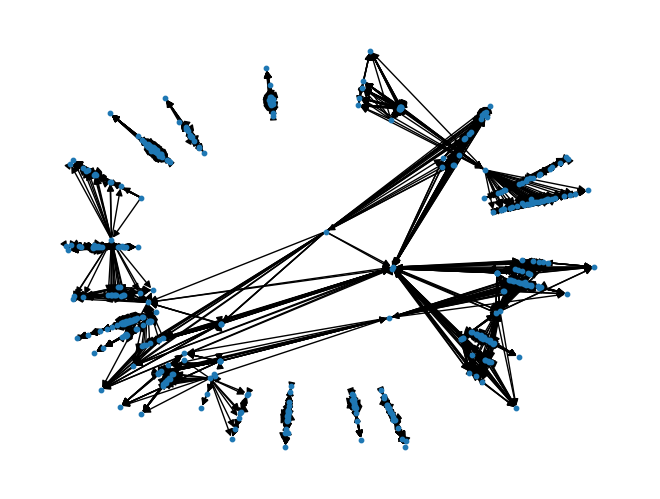

4855
438


In [28]:
# le dessin peut prendre beaucoup de temps, d'autant plus que le graph est grand
def dessine_graph(G):
    nx.draw(G, with_labels=True)
dessine_graph(graphe)

# 2. Collaborateurs en commun

In [ ]:
def colab_en_commun(G, u, v):
    """
    Retourne l'ensemble des collaborateurs communs entre deux acteurs du graphe G.

    Args:
        G (networkx.classes.digraph.DiGraph): Le graphe dans lequel rechercher les collaborateurs communs.
        u (node): un acteur.
        v (node): un  autre acteur.

    Returns:
        set: Un ensemble des collaborateurs communs entre u et v.

    """
    collab_commun = set()
    if u not in G.nodes or v not in G.nodes:
        return None
    # on regarde les collaborateurs directes de u et v
    adjU = G.adj[u]
    adjV= G.adj[v]
    for i in adjU:
        for v in adjV:
            # pour chaque collaborateur direct en commun, ont ajoute à l'ensemble si celui-ci n'est pas déjà ajoutée,
            if i == v and i not in colab_en_commun: 
                collab_commun.add(i)# i ou v cela revient au même car i==v
    return collab_commun



La fonction calculer_centralite_acteur, permet d'optenir le centralite d'un acteur dans le graphe.

Nous utilisons la fonction closeness_centrality de networkx, qui permet d'optenir la centralité de l'acteur en utilisant le parcour en largeur.

In [44]:
def calculer_centralite_acteur(Gc, acteur):
    return nx.closeness_centrality(Gc, u=acteur)

print(calculer_centralite_acteur(Graphe, "Tommy Lee Jones"))

0.002288329519450801


La fonction trouver_acteur_plus_central permet d'optenir l'acteur qui est le plus au centre du Graphe
Pour cela nous utilison encore la fonction closeness_centrality de networkx, pour avoir la centralité de toute les acteurs du graphe, puis optenir le maximum

In [45]:
def trouver_acteur_plus_central_networkx(G):
    noeud_proximite = nx.closeness_centrality(G)
    noeud_central = max(noeud_proximite, key=noeud_proximite.get)
    return noeud_central


# print(trouver_acteur_plus_central_networkx(Graphe))

In [46]:
def distance_maximale_entre_acteurs_networkx(G):
    distances = []
    for acteur1 in G.nodes():
        for acteur2 in G.nodes():
            if acteur1 != acteur2:
                try:
                    distance = nx.shortest_path_length(G, acteur1, acteur2)
                    distances.append(distance)
                except nx.NetworkXNoPath:
                    # Si aucun chemin n'existe entre les acteurs, la distance est infinie
                    distances.append(0)  # Distance 0 pour représenter une distance infinie
    distance_max = max(distances)
    return distance_max

print(distance_maximale_entre_acteurs_networkx(Graphe))

4


In [47]:
def collaborateurs_proches(G,u,k): # parcours en largeur
    """Fonction renvoyant l'ensemble des acteurs à distance au plus k de l'acteur u dans le graphe G. La fonction renvoie None si u est absent du graphe.
    
    Parametres:
        G: le graphe
        u: le sommet de départ
        k: la distance depuis u
    """
    if u not in G.nodes:
        print(u,"est un illustre inconnu")
        return None
    collaborateurs = set()
    collaborateurs.add(u)
    for i in range(k): # on explore les sucesseurs des successeurs et ainsi de suite à un degrès k maximum du noeud u 
        collaborateurs_directs = set()
        for c in collaborateurs:
            for voisin in G.adj[c]:
                if voisin not in collaborateurs:
                    collaborateurs_directs.add(voisin)
        collaborateurs = collaborateurs.union(collaborateurs_directs)
    return collaborateurs

In [48]:
def distance_acteurs_iterative(G,u,v):
    distance = 1
    trouve = False
    if u not in G.nodes or v not in G.nodes:
        return None
    deja_vu = []
    collabs = collaborateurs_proches(G,u,distance)
    while distance <= 6 and not trouve:
        for acteur in collabs:
            if acteur not in deja_vu:
                if acteur == v:
                    trouve = True
                deja_vu.append(acteur)
        distance += 1
        collabs = collaborateurs_proches(G,u,distance)
    return distance

In [49]:
def trouver_acteur_plus_central (G,acteur):
    cpt = 0
    for acteur2 in G.nodes():
        if acteur != acteur2:
            distance = distance_acteurs_iterative(G,acteur,acteur2)
            cpt += distance
    return cpt/len(G.nodes)-1


In [50]:
def trouver_acteur_plus_central_dico (G,dico,acteur):
    if acteur in dico.keys():
        return dico[acteur]
    cpt = 0
    for acteur2 in G.nodes():
        if acteur != acteur2:
            distance = distance_acteurs_iterative(G,acteur,acteur2)
            cpt += distance
    return cpt/len(G.nodes)-1

In [51]:
def distance_maximale_entre_acteurs(G):
    distances = {}
    for acteur in G.nodes():
        distance = trouver_acteur_plus_central_dico(G,distances,acteur)
        distances[acteur] = distance
    distance_max = max(distances, key = distances.get)
    return distances[distance_max]
print(distance_maximale_entre_acteurs(Graphe))

5.9840182648401825


In [53]:
def distance(G, u, v):
    if u not in G.nodes or v not in G.nodes:
        return None
    visite = []  # liste des noeuds déjà visités
    file = [[u]]  # queue des chemins à explorer
    while file:
        chemin = file.pop(0)  #premier chemin de la file d'attente
        noeud_courant = chemin[-1]  #dernier noeud du chemin en cours
        if noeud_courant not in visite:
            voisins = G[noeud_courant] 
            for voisin in voisins:
                nouveau_chemin = list(chemin)  # copie du chemin en cours
                nouveau_chemin.append(voisin)  # ajoute le voisin au chemin
                file.append(nouveau_chemin)  # ajoute le nouveau chemin à la file d'attente
                if voisin == v:
                    return len(nouveau_chemin)
                if len(file) > G.number_of_nodes():
                    return 0  # dans le cas ou il n'y'a pas de relations entre les 2 acteurs, on ne retourne pas None pour la condition distance > val de la fonction eloignement_max(G)
        visite.append(noeud_courant)  # le noeud courant est compté comme visité


def eloignement_max(G):
    max = 0
    val = None
    for acteur1 in G.nodes:
        for acteur2 in G.nodes:
            if acteur1!= acteur2:
                distanceinit = distance(G,acteur1,acteur2)
                if val is None or distanceinit > val:
                    max = distanceinit
    return max
print(eloignement_max(Graphe))

None
